In [41]:
from __future__ import division 

import gym
import numpy as np
import random
import tensorflow as tf 
import tensorflow.contrib.slim as slim
import tensorflow.contrib.layers as initializer
import matplotlib.pyplot as plt
import scipy.misc
import os
import sys
%matplotlib inline

In [42]:
from gridworld_v04 import gameEnv
#env = gameEnv(partial=False, size=15)
#env.renderEnv()

In [43]:
class Agent():
    def __init__(self, hiddens = [256, 256, 256], num_frames = 4, state_size = 10,
                 action_size = 6, env=None, lr = 1e-3, batch_size = 32, num_episodes = 5000, pre_train_steps = 10000,
                 max_ep_length = 300, buffer_size = 50000, start_e = 1, final_e = 0.01, gamma = 0.99,
                 tau=0.001, update_freq = 5, load_model = False , logs_dir = "./logs_dir"):

        self.hiddens = hiddens # Size of the hidden layers
        self.num_frames = num_frames # Number of consecutive state frames
        self.state_size = state_size # Size of the state vector
        self.action_size = action_size  # Number of actions
        self.env = env # Save the environmet!
        self.lr=lr # learning rate of the optimizer
        self.batch_size=batch_size # Size of the experience sample batch
        self.num_episodes = num_episodes # Number of game environmet episodes in which we train
        self.pre_train_steps = pre_train_steps
        self.max_ep_length = max_ep_length # Maximun length (number of actions) of a single train episode
        self.buffer_size = buffer_size # Size of the experience replay buffer
        self.start_e = start_e # Inital value of the exploration coefficient
        self.final_e = final_e # Final value of the exploration coefficient
        self.gamma = gamma # Discount factor on the target Q-value
        self.tau = tau # Porcentage that determines how much are parameters of mainQN net modified by targetQN
        self.update_freq = update_freq # Frecuency of updates of the double DQN
        self.logs_dir = logs_dir # Path to store logs and checkpoints

        tf.reset_default_graph()

        # Instantiate the networks
        #self.mainQN = DQN("mainQN", state_size, action_size, hiddens, num_frames)
        self.mainQN = DQN("mainQN", len(self.env.objects) * 2, self.env.actions, hiddens, num_frames)
        self.targetQN = DQN("targetQN", len(self.env.objects) * 2, self.env.actions, hiddens, num_frames)

        init = tf.global_variables_initializer()
        trainables = tf.trainable_variables()

        self.target_ops = self.set_target_graph_vars(trainables, tau)

        # Create a experience replay buffer & score records
        self.exp_buffer = ExperienceBuffer()
        self.step_record = []
        self.reward_record = []

        self.model_saver = ModelSaver(self.logs_dir)
        
    def learn(self):
        print("Model Learning")
        init = tf.global_variables_initializer()
        sess = tf.Session()
        e = self.start_e
        current_step = 0 # previously total_steps

        self.model_saver = ModelSaver(self.logs_dir)

        with sess:

            sess.run(init)
           # if self.load_model == True:
           #     print('Loading Model...')
           #     model_saver.restore_model(sess)
           #     #ckpt = model_saver_restore_model(sess)

            # Set the target network to be equal to the primary network
            self.update_target_graph(self.target_ops, sess)

            # Start the pre train proces
            for episode in range(self.num_episodes):

                if episode % 100 == 0:
                    print("\n=====" + "Episode " + str(episode) + "starts =====" )

                episode_exp = ExperienceBuffer()

                #Reset environment and get first new observation
                s = self.env.reset()

                d = False # episode's "done" signal
                episode_reward_sum = 0
                episode_steps = 0

                #The Q-Network
                while episode_steps < self.max_ep_length: #If the agent take too long to win, end the trial.
                    episode_steps += 1

                    #Choose an action by greedily (with e chance of random action) from the Q-network
                    if np.random.rand(1) < e or current_step < self.pre_train_steps:
                        a = np.random.randint(0,4)
                    else:
                        a = sess.run(self.mainQN.predict,feed_dict={self.mainQN.state:[s]})[0]

                    s1,r,d = self.env.step(a)
                    current_step += 1
                    episode_exp.add(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # Save the experience to our episode buffer.

                    # Start train process
                    if current_step > self.pre_train_steps:

                        if e > self.final_e:
                            stepDrop = 1/10000
                            e -= stepDrop

                        if current_step % self.update_freq == 0:

                            train_batch = self.exp_buffer.sample(self.batch_size) #Get a random batch of experiences.

                            #Perform the Double-DQN update to the target Q-values
                            Q1 = sess.run(self.mainQN.predict,
                                          feed_dict={self.mainQN.state:np.vstack(train_batch[:,3])})

                            Q2 = sess.run(self.targetQN.Qout,
                                          feed_dict={self.targetQN.state:np.vstack(train_batch[:,3])})

                            end_multiplier = -(train_batch[:,4] - 1)
                            doubleQ = Q2[range(self.batch_size),Q1]
                            targetQ = train_batch[:,2] + (self.gamma*doubleQ*end_multiplier)

                            # Update the network with our target values.
                            _ = sess.run(self.mainQN.updateModel,
                                         feed_dict={self.mainQN.state:np.vstack(train_batch[:,0]),
                                         self.mainQN.targetQ:targetQ,
                                         self.mainQN.actions:train_batch[:,1]})

                            # Set the target network to be equal to the primary
                            self.update_target_graph(self.target_ops, sess)

                    episode_reward_sum += r
                    s = s1

                    if d == True:
                        break

                self.exp_buffer.add(episode_exp.buffer)
                self.step_record.append(episode_steps)
                self.reward_record.append(episode_reward_sum)

                #Periodically save the model.
                if episode % 1000 == 0:
                    self.model_saver.save_model(sess, episode)
                    print("Model save_model")

                if len(self.reward_record) % 10 == 0:
                    print(current_step, np.mean(self.reward_record[-10:]), e)
            ##
            self.model_saver.save_model(sess, self.num_episodes)
        print("Percent of succesful episodes: " + str(100*sum(self.reward_record)/self.num_episodes) + "%")

    """ Auxiliary Methods """
    # Originally called updateTargetGraph
    def set_target_graph_vars(self, tfVars, tau):
        total_vars = len(tfVars)
        op_holder = []

        for idx,var in enumerate(tfVars[0:total_vars//2]): # Select the first half of the variables (mainQ net)
            op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau)+((1-tau)*tfVars[idx+total_vars//2].value())))

        return op_holder

    
    # Originally called updateTarget
    def update_target_graph(self, op_holder, sess):
        for op in op_holder:
            sess.run(op)
         
    def test(self):
        step_record_t = []
        reward_record_t = []
        current_steps_t = 0
        
        load_model = True
        num_test_episodes = 3000
        
        
        with tf.Session() as sess:
            if load_model == True:
                print('Loading Model...')
                self.model_saver.restore_model(sess)
                
            for episode in range(num_test_episodes):
                s = self.env.reset_for_testing()
                d = False
                episode_steps_t = 0
                episode_reword_sum_t = 0

                #Q-Network
                while episode_steps_t < self.max_ep_length: 
                    episode_steps_t+=1
                    a = sess.run(self.mainQN.predict, feed_dict={self.mainQN.state:[s]})[0]
                    s1, r, d = self.env.step_for_testing(a)
                    
                    current_steps_t += 1
                    episode_reword_sum_t += r
                    s = s1
                    
                    if d == True:
                        break
                        
                step_record_t.append(episode_steps_t)
                reward_record_t.append(episode_reword_sum_t)

                # print(episode_reword_sum_t)

                if len(reward_record_t) % 10 == 0:
                    accumR = np.mean(reward_record_t[-10:])
                    log = str(current_steps_t) +"\t"+ str(accumR) 
                    print(log)
                    #f.write(log)
                
    
        final_log = "Percent of sucessful episodes: " + str(sum(reward_record_t)/num_test_episodes) + "%"
        print(final_log)
        return reward_record_t
        


In [44]:
class DQN():
    def __init__(self, net_name, state_size, action_size, hiddens, num_frames):
        self.net_name = net_name

        with tf.variable_scope(self.net_name):

            #self.state = tf.placeholder(shape=[None, num_frames, state_size], dtype=tf.float32)
            self.state = tf.placeholder(shape=[None, state_size], dtype=tf.float32)
            #self.input_state = tf.reshape(self.state, [-1, num_frames * state_size])

            # Weights of each layer
            self.W = {
                'W1': self.init_weight("W1", [state_size, hiddens[0]]),
                'W2': self.init_weight("W2", [hiddens[0], hiddens[1]]),
                'W3': self.init_weight("W3", [hiddens[1], hiddens[2]]),
                'AW': self.init_weight("AW", [hiddens[2]//2, action_size]),
               #'AW': self.init_weight("AW", [hiddens[2]//2, hiddens[2]]),
                'VM': self.init_weight("VM", [hiddens[2]//2, 1])
            }

            self.b = {
                'b1': self.init_bias("b1", hiddens[0]),
                'b2': self.init_bias("b2", hiddens[1]),
                'b3': self.init_bias("b3", hiddens[2])
            }

            # Layers
            self.hidden1 = tf.nn.relu(tf.add(tf.matmul(self.state, self.W['W1']), self.b['b1']))
            self.hidden2 = tf.nn.relu(tf.add(tf.matmul(self.hidden1, self.W['W2']), self.b['b2']))
            self.hidden3 = tf.nn.relu(tf.add(tf.matmul(self.hidden2, self.W['W3']), self.b['b3']))

            # Compute the Advantage, Value, and total Q value
            self.A, self.V = tf.split(self.hidden3, 2, 1)
            self.Advantage = tf.matmul(self.A, self.W['AW'])
            self.Value = tf.matmul(self.V, self.W['VM'])
            self.Qout = self.Value + tf.subtract(self.Advantage, tf.reduce_mean(self.Advantage, axis=1, keep_dims=True))

            # Calcultate the action with highest Q value
            self.predict = tf.argmax(self.Qout, 1)

            # Compute the loss (sum of squared differences)
            self.targetQ = tf.placeholder(shape=[None], dtype=tf.float32)
            self.actions = tf.placeholder(shape=[None], dtype=tf.int32)
            self.actions_one_hot = tf.one_hot(self.actions, action_size, dtype=tf.float32)

            self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_one_hot), axis=1)
            self.td_error = tf.square(self.targetQ - self.Q)
            self.loss = tf.reduce_mean(self.td_error)

            self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
            self.updateModel = self.trainer.minimize(self.loss)

    def init_weight(self, name, shape):
        return tf.get_variable(name=name, shape=shape, initializer=initializer.xavier_initializer())
                               #initializer=tf.contrib.layers.xavier_initializer())

    def init_bias(self, name, shape):
        return tf.Variable(tf.random_normal([shape]))
        #return tf.get_variable(name=name, shape=shape, initializer=tf.constant(np.random.rand(range(shape))))
                              # initializer= tf.random_initializer())

In [45]:
class ExperienceBuffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size

    def add(self, experience):

        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience) + len(self.buffer)) - self.buffer_size] = []

        self.buffer.extend(experience)

    def sample(self, size):
        return np.reshape(np.array(random.sample(self.buffer, size)),[size,5])

In [46]:
class ModelSaver():
    def __init__(self, path):
        self.saver = tf.train.Saver()
        self.ckptPath = path
        if not os.path.exists(path):
            os.makedirs(path)

    def restore_model(self, sess):
        ckpt = tf.train.get_checkpoint_state(self.ckptPath)
        self.saver.restore(sess, ckpt.model_checkpoint_path)

    def save_model(self, sess, num_episode):
        self.saver.save(sess, self.ckptPath+'/model-'+str(num_episode)+'.cptk')

In [47]:
class DrawGraph():
    def __init__(self, reward_record):
        self.reward_record = reward_record
  
    def plot(self):
        rMat = np.resize(np.array(self.reward_record), [len(self.reward_record)//100,100])
        rMean = np.average(rMat, 1)
        plt.plot(rMean)

Model Learning

=====Episode 0starts =====
Model save_model
4330 -69.9 1
8250 -57.7 1
12395 -62.0 0.7605000000000264
17395 -38.9 0.26050000000008144
22051 -10.1 0.009900000000093813
27051 -3.4 0.009900000000093813
30745 -6.8 0.009900000000093813
35160 -2.3 0.009900000000093813
37015 -1.4 0.009900000000093813
39340 1.6 0.009900000000093813

=====Episode 100starts =====
41764 2.6 0.009900000000093813
44887 1.4 0.009900000000093813
47131 1.5 0.009900000000093813
49302 3.0 0.009900000000093813
50587 3.0 0.009900000000093813
51851 3.3 0.009900000000093813
54418 1.7 0.009900000000093813
55833 2.9 0.009900000000093813
56912 3.4 0.009900000000093813
58110 3.0 0.009900000000093813

=====Episode 200starts =====
59532 3.4 0.009900000000093813
60005 3.9 0.009900000000093813
61491 3.5 0.009900000000093813
62367 3.4 0.009900000000093813
63646 3.0 0.009900000000093813
64886 3.7 0.009900000000093813
65496 3.7 0.009900000000093813
65922 3.4 0.009900000000093813
66417 3.7 0.009900000000093813
67363 3.8 

112341 3.9 0.009900000000093813
112454 3.9 0.009900000000093813
112521 4.0 0.009900000000093813

=====Episode 2400starts =====
112671 3.8 0.009900000000093813
112803 3.9 0.009900000000093813
112893 4.0 0.009900000000093813
112980 4.0 0.009900000000093813
113110 3.9 0.009900000000093813
113192 4.0 0.009900000000093813
113332 3.9 0.009900000000093813
113517 3.9 0.009900000000093813
113650 3.8 0.009900000000093813
113781 4.0 0.009900000000093813

=====Episode 2500starts =====
113898 3.8 0.009900000000093813
114077 3.6 0.009900000000093813
114189 3.8 0.009900000000093813
114345 3.9 0.009900000000093813
114501 3.7 0.009900000000093813
114596 4.0 0.009900000000093813
114800 3.8 0.009900000000093813
114938 3.5 0.009900000000093813
115142 3.9 0.009900000000093813
115234 3.9 0.009900000000093813

=====Episode 2600starts =====
115339 3.9 0.009900000000093813
115473 3.8 0.009900000000093813
115588 3.8 0.009900000000093813
115651 4.0 0.009900000000093813
115744 3.9 0.009900000000093813
115880 3.8 

147298 3.9 0.009900000000093813
147510 4.0 0.009900000000093813
147619 4.0 0.009900000000093813
147744 4.0 0.009900000000093813
147872 4.0 0.009900000000093813
148017 3.9 0.009900000000093813
148312 3.9 0.009900000000093813
148415 4.0 0.009900000000093813
148593 3.8 0.009900000000093813
148798 3.9 0.009900000000093813

=====Episode 4800starts =====
148956 4.0 0.009900000000093813
149180 4.0 0.009900000000093813
149270 4.0 0.009900000000093813
149534 3.9 0.009900000000093813
149678 4.0 0.009900000000093813
149808 4.0 0.009900000000093813
149965 4.0 0.009900000000093813
150135 4.0 0.009900000000093813
150366 4.0 0.009900000000093813
150608 3.8 0.009900000000093813

=====Episode 4900starts =====
150832 3.8 0.009900000000093813
151092 3.9 0.009900000000093813
151215 3.9 0.009900000000093813
151547 3.8 0.009900000000093813
151722 4.0 0.009900000000093813
151947 4.0 0.009900000000093813
152044 4.0 0.009900000000093813
152195 4.0 0.009900000000093813
152470 3.9 0.009900000000093813
152562 4.0

200576 4.0 0.009900000000093813
200689 4.0 0.009900000000093813
200754 4.0 0.009900000000093813
200864 4.0 0.009900000000093813
200949 4.0 0.009900000000093813
201033 4.0 0.009900000000093813
201194 3.9 0.009900000000093813

=====Episode 7100starts =====
201280 4.0 0.009900000000093813
201390 4.0 0.009900000000093813
201498 4.0 0.009900000000093813
201632 4.0 0.009900000000093813
201825 3.9 0.009900000000093813
202041 3.9 0.009900000000093813
202402 3.9 0.009900000000093813
202510 4.0 0.009900000000093813
202739 4.0 0.009900000000093813
202817 4.0 0.009900000000093813

=====Episode 7200starts =====
202940 4.0 0.009900000000093813
203088 3.9 0.009900000000093813
203216 4.0 0.009900000000093813
203328 3.9 0.009900000000093813
203506 4.0 0.009900000000093813
203683 4.0 0.009900000000093813
203807 4.0 0.009900000000093813
203974 4.0 0.009900000000093813
204094 4.0 0.009900000000093813
204260 3.9 0.009900000000093813

=====Episode 7300starts =====
204355 4.0 0.009900000000093813
204563 3.9 

228766 4.0 0.009900000000093813
228880 4.0 0.009900000000093813
229003 4.0 0.009900000000093813
229079 4.0 0.009900000000093813

=====Episode 9400starts =====
229185 4.0 0.009900000000093813
229346 4.0 0.009900000000093813
229434 4.0 0.009900000000093813
229564 3.9 0.009900000000093813
229660 4.0 0.009900000000093813
229805 4.0 0.009900000000093813
229888 4.0 0.009900000000093813
229977 4.0 0.009900000000093813
230096 3.9 0.009900000000093813
230219 4.0 0.009900000000093813

=====Episode 9500starts =====
230327 4.0 0.009900000000093813
230438 4.0 0.009900000000093813
230607 3.9 0.009900000000093813
230724 4.0 0.009900000000093813
230811 4.0 0.009900000000093813
231005 4.0 0.009900000000093813
231117 3.9 0.009900000000093813
231256 4.0 0.009900000000093813
231404 4.0 0.009900000000093813
231650 4.0 0.009900000000093813

=====Episode 9600starts =====
231778 4.0 0.009900000000093813
231917 4.0 0.009900000000093813
232064 4.0 0.009900000000093813
232233 4.0 0.009900000000093813
232335 4.0 

[2017-06-12 23:45:29,642] Restoring parameters from ./logs_dir/model-10000.cptk


67	4.0
163	4.0
254	4.0
346	4.0
447	4.0
556	4.0
651	4.0
729	4.0
804	4.0
873	4.0
952	4.0
1042	4.0
1127	4.0
1240	4.0
1334	4.0
1426	4.0
1514	4.0
1592	4.0
1690	4.0
1787	4.0
1872	4.0
1953	4.0
2043	4.0
2122	4.0
2191	4.0
2290	4.0
2395	4.0
2469	4.0
2561	4.0
2648	4.0
2732	4.0
2825	4.0
2935	4.0
3025	4.0
3128	4.0
3217	4.0
3298	4.0
3402	4.0
3487	4.0
3610	4.0
3684	4.0
3752	4.0
3826	4.0
3910	4.0
4029	4.0
4128	4.0
4223	4.0
4339	4.0
4440	4.0
4536	4.0
4606	4.0
4702	4.0
4802	4.0
4889	4.0
4955	4.0
5064	4.0
5173	4.0
5267	4.0
5370	4.0
5465	4.0
5525	4.0
5617	4.0
5709	4.0
5805	4.0
5888	4.0
5962	4.0
6049	4.0
6159	4.0
6238	4.0
6373	4.0
6502	4.0
6619	4.0
6702	4.0
6796	4.0
6902	4.0
7007	4.0
7112	4.0
7178	4.0
7273	4.0
7362	4.0
7448	4.0
7560	4.0
7659	4.0
7766	4.0
7877	4.0
7970	4.0
8080	4.0
8172	4.0
8281	4.0
8368	4.0
8474	4.0
8552	4.0
8650	4.0
8752	4.0
8842	4.0
8925	4.0
9020	4.0
9108	4.0
9201	4.0
9286	4.0
9405	4.0
9518	4.0
9614	4.0
9711	4.0
9818	4.0
9894	4.0
9968	4.0
10061	4.0
10159	4.0
10268	4.0
10344	4.0
10459	4.0

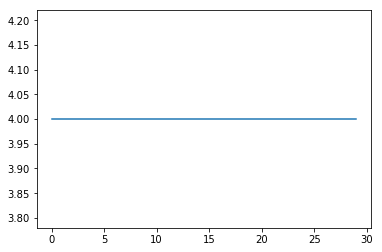

In [48]:
def main():
    env = gameEnv(partial = False, size=15)

    #agent = Agent([256, 256, 256], 4, 10, 6, env, 1e-3, 32, 10000, 100, 50000,
    #              1, 0.01, 10000, 0.99, 0.001, 5, False, "./log_dir")

    # The parameters of Agent class are as follows:
    # hiddens, num_frames, state_size, action_size, env, lr, batch_size, num_episodes, pre_train_steps,
    # max_ep_length, buffer_size, start_e, final_e, gamma, tau, update_freq, load_model, logs_dir
    
    
    agent = Agent([256, 256, 256], 4, 10, 6, env, 1e-3, 32, 10000, 10000, 500, 50000, 1, 0.01, 0.99, 0.001, 5, False, "./logs_dir")
    agent.learn()
    
    reward_record_t = agent.test()
    graph = DrawGraph(reward_record_t)
    graph.plot()
    
if __name__ == '__main__':
    main()
